In [13]:
# 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 설정함
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [14]:
# 동일한 결과를 재현하기 위해서 random seed 고정
import numpy as np

np.random.seed(777)

In [15]:
# 모델 학습 시 불필요한 출력을 끄도록 함 (warning)
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

# 1. 데이터 준비

* 타겟 데이터

1978 보스턴 주택 가격

506개 타운의 주택 가격 중앙값 (단위 1,000 달러)

* 특징 데이터

CRIM: 범죄율

INDUS: 비소매상업지역 면적 비율

NOX: 일산화질소 농도

RM: 주택당 방 수

LSTAT: 인구 중 하위 계층 비율

B: 인구 중 흑인 비율

PTRATIO: 학생/교사 비율

ZN: 25,000 평방피트를 초과 거주지역 비율

CHAS: 찰스강의 경계에 위치한 경우는 1, 아니면 0

AGE: 1940년 이전에 건축된 주택의 비율

RAD: 방사형 고속도로까지의 거리

DIS: 직업센터의 거리

TAX: 재산세율

In [16]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [17]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [18]:
print(train_targets) # 단위: 천 달러

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6
 32.2 13.1

# 2. 데이터 전처리

In [19]:
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

# 테스트 셋도 훈련 셋에서 계산된 mean과 std를 동일하게 사용함
# 만약 각각 정규화를 수행해버리면, 학습 결과 적용이 불가능해짐
test_data -= mean
test_data /= std

# 3. 네트워크 정의

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1)) # 회귀 모델 (출력층에 활성화 함수 없음)
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

# 4. (K-겹 교차 검증을 사용한) 모델 학습

In [21]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('>> fold ', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                         train_data[(i+1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],
                                            train_targets[(i+1) * num_val_samples:]],
                                           axis=0)
    
    model = build_model()
    model.fit(partial_train_data, 
              partial_train_targets,
              epochs = num_epochs,
              batch_size = 1,
              verbose = 0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0) #평균적인 성능
    #val_mse=로스펑션, val_mae=메트릭스로 추가 된거
    all_scores.append(val_mae)

print('finished!!')

>> fold  0
>> fold  1
>> fold  2
>> fold  3
finished!!


In [22]:
print(all_scores)
mean = np.mean(all_scores)
stddev = np.std(all_scores)

print(u'%.2f \u00B1(%.2f)'%(mean, stddev))

[2.1388724, 2.2792442, 3.0671082, 2.6236222]
2.53 ±(0.36)


In [23]:
'''
4-fold의 평균 validation MAE 그래프 그리기
'''

print(model.metrics_names) #모델이 무슨 메트릭스를 가지고있나

['loss', 'mean_absolute_error']


In [32]:
#오버피팅 막기위한 코드


num_epochs = 100
all_mae_histories = []

for i in range(k):
    print('>> fold ', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                         train_data[(i+1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],
                                            train_targets[(i+1) * num_val_samples:]],
                                           axis=0)
    
    model = build_model()
    hist = model.fit(partial_train_data, 
                     partial_train_targets,
                     epochs = num_epochs,
                     batch_size = 1,
                     verbose = 0,
                     validation_data = (val_data, val_targets))    #
    
    mae_history = hist.history['val_mean_absolute_error']  #validation이면 자동적으로 val_붙음
    #mae_history 각에포크의 히스토리를 저장
    all_mae_histories.append(mae_history)  #k폴드동안 각각의 500에포크동안의 mae히스토리
    
print('finished!!')

>> fold  0
>> fold  1
>> fold  2
>> fold  3
finished!!


In [25]:
print(all_mae_histories) 

[[3.8896322, 3.3154564, 2.9586387, 2.9566686, 2.4230547, 2.3462894, 2.3695016, 2.2647204, 2.1810997, 2.1375594, 2.2042649, 2.2058802, 2.0766368, 2.3583202, 2.2505343, 2.0165262, 2.0409071, 1.9477583, 2.0784292, 2.197078, 2.1677904, 2.102056, 2.0029047, 2.0875015, 1.9548599, 1.985107, 2.0197284, 2.0167727, 1.9548997, 1.8693407, 2.1931787, 1.9817698, 2.0255299, 2.1552105, 1.9938122, 1.9416299, 2.1491969, 2.2334101, 1.859305, 2.0855286, 2.1075733, 2.0065413, 2.5332084, 1.9369332, 2.0287569, 2.0204706, 2.0548391, 2.011865, 1.8829229, 1.9932177, 1.9301742, 1.9869859, 2.0805168, 1.8872457, 2.1345897, 2.1699936, 1.9998386, 1.9042664, 1.8353431, 1.9174227, 2.063573, 2.1675882, 2.2172246, 2.0395982, 1.9604955, 2.1417131, 1.9493402, 1.9596561, 2.2869933, 2.1389468, 1.9925097, 1.9681059, 2.0340893, 2.3055437, 2.210063, 2.2423475, 1.9742935, 2.4293382, 2.540465, 2.1383693, 2.0671723, 2.1597168, 2.2557192, 1.9253368, 2.1506393, 2.1931543, 2.1084714, 2.0095632, 2.2599607, 2.2284267, 2.3921242, 2.092

In [26]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

print(average_mae_history)

[4.7033143, 3.4950428, 3.157642, 2.9761553, 2.8495016, 2.790494, 2.8656766, 2.6528635, 2.605695, 2.6006963, 2.6035655, 2.5446491, 2.5777955, 2.5992873, 2.604393, 2.491448, 2.5366871, 2.5112, 2.6017606, 2.548755, 2.461271, 2.4681625, 2.4650424, 2.5777016, 2.4029508, 2.4437957, 2.4710548, 2.404573, 2.327455, 2.3563623, 2.5071685, 2.3023825, 2.3752158, 2.585723, 2.4852896, 2.4306836, 2.4977129, 2.4230962, 2.4731932, 2.4239995, 2.4559383, 2.3848877, 2.6083267, 2.4231782, 2.3750086, 2.4436374, 2.4288816, 2.4094768, 2.459464, 2.432551, 2.3963642, 2.572448, 2.5272374, 2.3771958, 2.6010673, 2.4381473, 2.5387735, 2.3544505, 2.4464118, 2.3514109, 2.3755813, 2.4745817, 2.4050858, 2.551601, 2.4041262, 2.46855, 2.4063327, 2.4488387, 2.563029, 2.5483804, 2.4840555, 2.5312145, 2.496374, 2.6538668, 2.501402, 2.5734859, 2.4275913, 2.592627, 2.5980117, 2.465921, 2.680695, 2.5190234, 2.5060682, 2.4875433, 2.5989099, 2.613205, 2.5298853, 2.5150592, 2.6254814, 2.5899305, 2.5643702, 2.527177, 2.4275475, 2.4

In [27]:
average_mae_history = []
for epoch in range(num_epochs):
    average_mae_per_epoch = []
    
    for mae_history in all_mae_histories: # 4개 fold 반복
        average_mae_per_epoch.append(mae_history[epoch])
    
    mean = np.mean(average_mae_per_epoch)
    average_mae_history.append(mean)

print(average_mae_history)

[4.7033143, 3.4950428, 3.157642, 2.9761553, 2.8495016, 2.790494, 2.8656766, 2.6528635, 2.605695, 2.6006963, 2.6035655, 2.5446491, 2.5777955, 2.5992873, 2.604393, 2.491448, 2.5366871, 2.5112, 2.6017606, 2.548755, 2.461271, 2.4681625, 2.4650424, 2.5777016, 2.4029508, 2.4437957, 2.4710548, 2.404573, 2.327455, 2.3563623, 2.5071685, 2.3023825, 2.3752158, 2.585723, 2.4852896, 2.4306836, 2.4977129, 2.4230962, 2.4731932, 2.4239995, 2.4559383, 2.3848877, 2.6083267, 2.4231782, 2.3750086, 2.4436374, 2.4288816, 2.4094768, 2.459464, 2.432551, 2.3963642, 2.572448, 2.5272374, 2.3771958, 2.6010673, 2.4381473, 2.5387735, 2.3544505, 2.4464118, 2.3514109, 2.3755813, 2.4745817, 2.4050858, 2.551601, 2.4041262, 2.46855, 2.4063327, 2.4488387, 2.563029, 2.5483804, 2.4840555, 2.5312145, 2.496374, 2.6538668, 2.501402, 2.5734859, 2.4275913, 2.592627, 2.5980117, 2.465921, 2.680695, 2.5190234, 2.5060682, 2.4875433, 2.5989099, 2.613205, 2.5298853, 2.5150592, 2.6254814, 2.5899305, 2.5643702, 2.527177, 2.4275475, 2.4

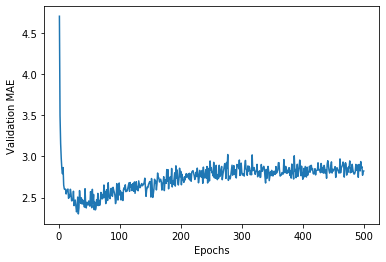

In [28]:
# 학습 시각화
import matplotlib.pyplot as plt

# matplotlib이 Jupyter notebook 셀 안에서 생성되도록 함
# https://versusall.tistory.com/entry/Jupyter-Notebook-4-%EC%99%B8%EB%B6%80%EC%B0%BD%EC%97%90%EC%84%9C-%EA%B7%B8%EB%9E%98%ED%94%84-%EA%B7%B8%EB%A6%AC%EA%B8%B0-matplotlib-inline-qt-tk%C2%B6
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

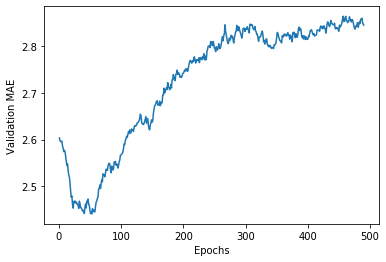

In [29]:
'''
시계열 신호에 지수 이동 평균(exponential moving averge) 필터링
'''
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            prev = smoothed_points[-1]
            smoothed_points.append(prev*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# 5. (과대적합 되기 전까지) 모델 학습

In [30]:
# 기존 model 객체를 사용하면 이어서 학습되므로, 새로운 model 객체를 생성함
model = build_model()
model.fit(train_data, 
          train_targets,
          epochs = 80,
          batch_size = 16,
          verbose = 1)

Epoch 1/80
404/404 [==============================] - 0s 1ms/sample - loss: 489.6918 - mean_absolute_error: 20.2216
Epoch 2/80
404/404 [==============================] - 0s 306us/sample - loss: 321.1310 - mean_absolute_error: 15.6377
Epoch 3/80
404/404 [==============================] - 0s 338us/sample - loss: 168.5900 - mean_absolute_error: 10.4475
Epoch 4/80
404/404 [==============================] - 0s 346us/sample - loss: 82.7442 - mean_absolute_error: 7.0129
Epoch 5/80
404/404 [==============================] - 0s 346us/sample - loss: 50.7353 - mean_absolute_error: 5.4320
Epoch 6/80
404/404 [==============================] - 0s 326us/sample - loss: 33.1123 - mean_absolute_error: 4.3060
Epoch 7/80
404/404 [==============================] - 0s 323us/sample - loss: 24.6641 - mean_absolute_error: 3.5932
Epoch 8/80
404/404 [==============================] - 0s 333us/sample - loss: 20.7836 - mean_absolute_error: 3.2603
Epoch 9/80
404/404 [==============================] - 0s 358us/sampl

# 6. 테스트셋으로 성능 평가하기

In [31]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print('test MSE score: %.3f', test_mse_score)
print('test MAE score: %.3f', test_mae_score)

102/102 [==============================] - 0s 2ms/sample - loss: 19.5454 - mean_absolute_error: 2.6576
test MSE score: %.3f 19.545394598268995
test MAE score: %.3f 2.6576152
